In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange, tqdm

In [2]:
wine = load_wine(as_frame=True).frame
X_train, X_val, y_train, y_val = train_test_split(wine.drop(columns = "target"), wine['target'], random_state=44)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.labels = torch.tensor(Y).float()
        self.data = torch.tensor(X).float()
        self.current = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = int(self.labels[idx])
        return data, label
    
    def __iter__(self):
        self.current = 0
        return self
    
    def __next__(self):
        if self.current < self.__len__():
            self.current += 1
            return self.__getitem__(self.current-1)
        raise StopIteration

In [48]:
batch_size = 100

train_data = CustomDataset(X_train.values, y_train.values)
test_data = CustomDataset(X_val.values, y_val.values)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [5]:
def init_batch_generator(dataloader: torch.utils.data.DataLoader):
    """
    Возвращает функцию, вызов которой возвращает следующие batch_size
    примеров и им соответствуюющих меток из train_data, train_labels.
    
    Примеры выбираются последовательно, по кругу. Массивы с входными 
    примерами и метками классов перемешиваются в начале каждого круга.
    """
    def f():
        while True:
            for i, (images, labels) in enumerate(dataloader):
                yield images, labels
    return f()

In [104]:
class Classifier2(nn.Module):
    def __init__(self,
                 size_in: int = 13,
                 size_out: int = 3): 
        super(Classifier2, self).__init__()
        self.fc1 = nn.Linear(size_in, 8)
        self.fc2 = nn.Linear(8, size_out)
        self.LReLU = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.LReLU(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.LReLU(x)
        return x

In [133]:
net = Classifier2()

In [163]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.00001)

In [97]:
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)

In [56]:
class Metrics:
    def __init__(self, lables, predicted):
        leble = lables.unique()
        self.matrix = np.zeros((leble.size, leble.size))
        for i in range(leble.size):
            for j in range(leble.size):
                self.matrix[i, j]=((leble[j]==predicted)*(lables==leble[i])).sum()
    
    def accuracy(self):
        return np.array([self.matrix.diagonal().sum()/self.matrix.sum()
                         if self.matrix.diagonal().sum() != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def precision(self):
        return np.array([self.matrix[i,i]/self.matrix[i,:].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def recall(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def FPR(self):
        return np.array([(self.matrix[i,:].sum()-self.matrix[i,i])/(self.matrix[:,i].sum()+self.matrix[i,:].sum()-2*self.matrix[i,i])
                         if (self.matrix[i,:].sum()-self.matrix[i,i]) != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def TPR(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def F(self, b = 1):
        b=b**2
        return (1+b)*self.precision()*self.recall()/(b*self.precision()+self.recall())
    def all(self, b=1):
        return pd.DataFrame(np.array([self.accuracy(), self.precision(), self.recall(), self.FPR(), self.TPR(), self.F(b)]).T,
                            columns=["accuracy", "precision", "recall", "FPR", "TPR", "F"])

In [87]:
def train(net: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          num_epochs: int = 5):
    net.train()

    data_iterator = init_batch_generator(train_loader)
    progress = trange(num_epochs*len(train_loader))
    loss_arr = list()
    accuracy_arr = list()

    for epoch in progress:
        data, labels = next(data_iterator)
        outputs = net(data)
        loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(3)] for i in range(len(labels))]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        loss_arr.append(loss.item())
        accuracy_arr.append(correct)

        progress.set_postfix_str(f"Loss: {loss.item() :.4f}, Accuracy: {(correct / total) * 100 :.2f}%")
    return loss_arr, accuracy_arr

In [164]:
out = train(net, train_loader, criterion, optimizer, 1000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

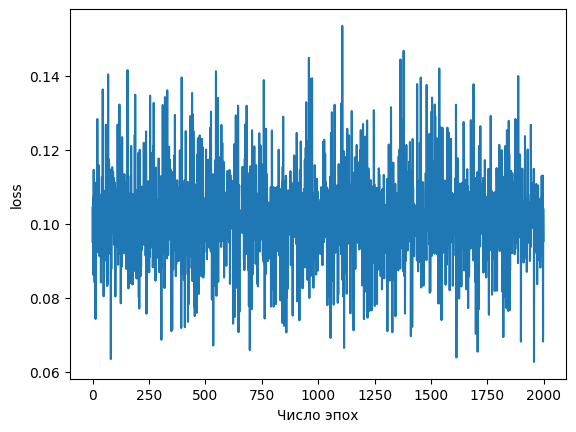

In [165]:
plt.plot(out[0])
plt.xlabel('Число эпох')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy, %')

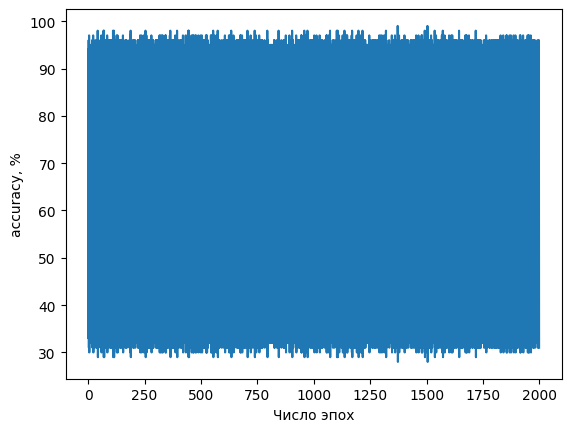

In [166]:
plt.plot(out[1])
plt.xlabel('Число эпох')
plt.ylabel('accuracy, %')

In [167]:
_, predicted = torch.max(net(torch.tensor(X_val.values).float()), 1)
metrics = Metrics(y_val, predicted)
metrics.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.955556,0.944444,1.000000,1.0,1.000000,0.971429
1,0.955556,0.944444,0.944444,0.5,0.944444,0.944444
2,0.955556,1.000000,0.900000,0.0,0.900000,0.947368
